# Generating Analysis Ready Cloud Optimized (ARCO) datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

## Load the ESGF Virtual Aggregation inventory

Load the CSV inventory and locate the datasets of interest (refer to the [tutorial](getting-started.ipynb) for further information).

In [3]:
df = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip")

subset = df.query("model == 'MIROC-ES2H' & product == 'ScenarioMIP' & experiment == 'ssp245' & variable == 'tas' & institution == 'MIROC' & table == 'Amon'")

subset

/tmp/ipykernel_66025/4005755707.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip")


,location,project,product,institution,model,experiment,subexperiment,table,variable,grid_label,version,replica
1957659,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,ScenarioMIP,MIROC,MIROC-ES2H,ssp245,NaN,Amon,tas,gn,v20230524,NaN


Locate the replica of interest.

In [4]:
url = subset.iloc[0,0]
url

'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_MIROC_MIROC-ES2H_ssp245_Amon_gn_v20230524/CMIP6_ScenarioMIP_MIROC_MIROC-ES2H_ssp245_Amon_tas_gn_v20230524.ncml'

## Load the dataset and store in ARCO format

In [5]:
ds = xarray.open_dataset(url).chunk({"variant_label": 1, "time": 736})
ds["tas"]

<xarray.DataArray 'tas' (variant_label: 3, time: 1032, lat: 128, lon: 256)> Size: 406MB
dask.array<xarray-tas, shape=(3, 1032, 128, 256), dtype=float32, chunksize=(1, 736, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 1kB -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon            (lon) float64 2kB 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
    height         float64 8B ...
  * time           (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-...
  * variant_label  (variant_label) |S64 192B b'r1i1p4f2' b'r2i1p4f2' b'r3i1p4f2'
Attributes:
    long_name:        Near-Surface Air Temperature
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    T2
    cell_methods:     area: time: mean
    cell_measures:    area: areacella
    history:          2023-01-07T12:58:44Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1 128 256]

Remove any previous existing of the ARCO dataset.

In [6]:
!rm -rf arco.zarr

Dump a specific subset from the ESGF Virtual Aggregation dataset to a Zarr store.

In [7]:
%time ds.sel(time=slice("20800101", "21001231")).to_zarr("arco.zarr")

CPU times: user 133 ms, sys: 16.1 ms, total: 149 ms
Wall time: 19.3 s


## Analyzing ARCO datasets

We can analyze ARCO datasets using xarray.

In [8]:
arco = xarray.open_zarr("arco.zarr")
arco["tas"]

<xarray.DataArray 'tas' (variant_label: 3, time: 252, lat: 128, lon: 256)> Size: 99MB
dask.array<open_dataset-tas, shape=(3, 252, 128, 256), dtype=float32, chunksize=(1, 252, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height         float64 8B ...
  * lat            (lat) float64 1kB -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon            (lon) float64 2kB 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
  * time           (time) datetime64[ns] 2kB 2080-01-16T12:00:00 ... 2100-12-...
  * variant_label  (variant_label) |S64 192B b'r1i1p4f2' b'r2i1p4f2' b'r3i1p4f2'
Attributes:
    _ChunkSizes:      [1, 128, 256]
    _CoordinateAxes:  variant_label height time lat lon
    cell_measures:    area: areacella
    cell_methods:     area: time: mean
    comment:          near-surface (usually, 2 meter) air temperature
    history:          2023-01-07T12:58:44Z altered by CMOR: Treated scalar di...
    long_name:        Near-Surface Air Temperature
    original_name:    T2
    standard_name:    air_temperature
    units:            K

Visualize the multimember evolution of surface temperature.

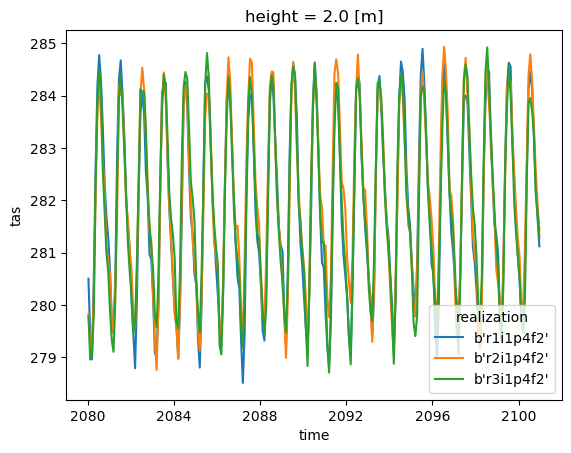

In [9]:
arco["tas"].mean(["lat", "lon"]).compute().plot.line(x="time")